# Image Compressed Sensing

In [1]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array, array_to_img, save_img
import scipy.fftpack as spfft
import cvxpy as cvx

In [2]:
#define discrete cosine transform and inverse discrete cosine transform
def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

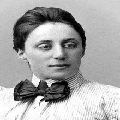

In [3]:
#load image with specified color and size
img = load_img('Noether.jpg', color_mode = "grayscale", target_size=(120,120))
img

In [4]:
#convert to raw data
img_array = img_to_array(img)
#save_img('emmy1.jpg',img_array)

#size of image
ny,nx,_ =  img_array.shape

In [5]:
# calculate how much of 0.5 of the raw data to be kept
k = round(nx*ny * 0.5)

#choose k random samples of indices
ri = np.random.choice(nx*ny, k, replace=False) 

# keep random 50% of the image and remove the rest
img_50 = img_array.T.flat[ri]

img_50 = np.expand_dims(img_50, axis=1)

In [6]:
#Define a matrix with the same size as the original image 
#all entries 255 corresponding to white color
vis_50= 255 * np.ones(img_array.shape)

#replace the previously chosen random indices to same values as the original image
vis_50.T.flat[ri] = img_array.T.flat[ri]
#save_img('emmy4.jpg',vis_50)

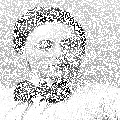

In [7]:
array_to_img(dct2(idct2(vis_50)))

In [8]:
#Define the matrix of measurement operators
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )

In [10]:
A = A[ri,:]

In [12]:
#L1 optimization
vx = cvx.Variable(nx * ny)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A@vx == img_50.reshape(7200,)]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)

                                     CVXPY                                     
                                    v1.1.17                                    
(CVXPY) Jun 19 07:55:17 PM: Your problem has 14400 variables, 1 constraints, and 0 parameters.
(CVXPY) Jun 19 07:55:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 19 07:55:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 19 07:55:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 19 07:55:17 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jun 19 07:55:17 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

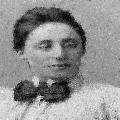

In [13]:
#reconstructed images
img_rec = np.array(vx.value).squeeze()

#stack columns
img_rec = img_rec.reshape(nx, ny).T 
img_rec = idct2(img_rec)
array_to_img(img_rec.reshape(120,120,1))